---
---
This notebook is made for creating our second model if there's a case when bank got new data injection from new and fresh customer that has never be given a campaign at all.  
This project still using the same dataset but only drop some columns which represent historical data (prev qty contact, previous days, previous outcome, last contact duration, last contact month, last contact day, contact type, and qty contact).  

---
---

In [1]:
# Base library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Statistics
from scipy.stats import skew, normaltest, kstest, shapiro

# Preprocessing
import ppscore as pps
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from custom_preprocessing import *
from SegmentPerformance import *


# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import (train_test_split, cross_val_score, cross_val_predict, StratifiedKFold,
                                    learning_curve, ShuffleSplit)

# Evaluation
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             confusion_matrix, classification_report,ConfusionMatrixDisplay, brier_score_loss)
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Deployment
import pickle
import warnings
warnings.filterwarnings('ignore')

---
---
# **1. Data Understanding**

---
---

In [2]:
# Read dataset
dfraw = pd.read_csv("bank-additional-model2.csv")

In [3]:
dfraw.head()

,age,job,marital,education,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   emp.var.rate    41188 non-null  float64
 8   cons.price.idx  41188 non-null  float64
 9   cons.conf.idx   41188 non-null  float64
 10  euribor3m       41188 non-null  float64
 11  nr.employed     41188 non-null  float64
 12  y               41188 non-null  object 
dtypes: float64(5), int64(1), object(7)
memory usage: 4.1+ MB


In [5]:
# Rename target column
dfraw = dfraw.rename(columns={'y': 'Deposit'})

# Replace 'Yes' with 1 and 'No' with 0
dfraw['Deposit'] = dfraw['Deposit'].replace({'yes': 1, 'no': 0})
dfraw.head()

,age,job,marital,education,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
0,56,housemaid,married,basic.4y,no,no,no,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,1.1,93.994,-36.4,4.857,5191.0,0


In [6]:
# Check duplicates

dfraw.duplicated().sum()

6840

In [7]:
# Drop Duplicates
dfraw.drop_duplicates(inplace=True)
dfraw.shape

(34348, 13)

In [8]:
# Check Descriptive Summary

display(dfraw.describe(),
        dfraw.describe(include='object'))

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
count,34348.000000,34348.000000,34348.000000,34348.000000,34348.000000,34348.000000,34348.000000
mean,40.397723,0.038509,93.584278,-40.482066,3.574639,5164.494710,0.127839
std,10.614584,1.592221,0.594689,4.666816,1.754936,73.875726,0.333915
min,17.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,39.000000,1.100000,93.918000,-41.800000,4.857000,5191.000000,0.000000
75%,48.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


,job,marital,education,default,housing,loan
count,34348,34348,34348,34348,34348,34348
unique,12,4,8,3,3,3
top,admin.,married,university.degree,no,yes,no
freq,8289,20714,9849,26893,17718,27498


In [9]:
# Define Variable to Store Numerical Features
numerical_cols = dfraw.select_dtypes(include=['int','float64']).columns[:].tolist()

# Define Variable to Store Categorical Features
categorical_cols = dfraw.select_dtypes(include=['object']).columns[:].tolist()

# Apply normality tests and calculate skewness
alpha = 0.05

agospearson_pvalues = [normaltest(dfraw[col]).pvalue for col in numerical_cols]
ks_pvalues = [kstest(dfraw[col], 'norm').pvalue for col in numerical_cols]
shapiro_values = [shapiro(dfraw[col]).pvalue for col in numerical_cols]
skew_values = [skew(dfraw[col]) for col in numerical_cols]
skewness_type = ['Right-Skewed' if skew > 0 else 'Left-Skewed' if skew < 0 else 'No Skew' for skew in skew_values]

# Determine if the distribution is normal
normal_distribution = [
    'Yes' if (p > alpha and ks_p > alpha and sw_p > alpha) else 'No'
    for p, ks_p, sw_p in zip(agospearson_pvalues, ks_pvalues, shapiro_values)]

# Create DataFrame with the results
pd.DataFrame({
    'column': numerical_cols,
    'skewness': [round(value, 2) for value in skew_values],
    'skewness_type': skewness_type,
    'agosp_pvalue': [round(value, 4) for value in agospearson_pvalues],
    'ks_pvalue': [round(value, 4) for value in ks_pvalues],
    'sw_pvalue': [round(value, 4) for value in shapiro_values],
    'normal_distribution': normal_distribution
})

,column,skewness,skewness_type,agosp_pvalue,ks_pvalue,sw_pvalue,normal_distribution
0,age,0.73,Right-Skewed,0.0,0.0,0.0,No
1,emp.var.rate,-0.69,Left-Skewed,0.0,0.0,0.0,No
2,cons.price.idx,-0.25,Left-Skewed,0.0,0.0,0.0,No
3,cons.conf.idx,0.34,Right-Skewed,0.0,0.0,0.0,No
4,euribor3m,-0.66,Left-Skewed,0.0,0.0,0.0,No
5,nr.employed,-1.00,Left-Skewed,0.0,0.0,0.0,No
6,Deposit,2.23,Right-Skewed,0.0,0.0,0.0,No


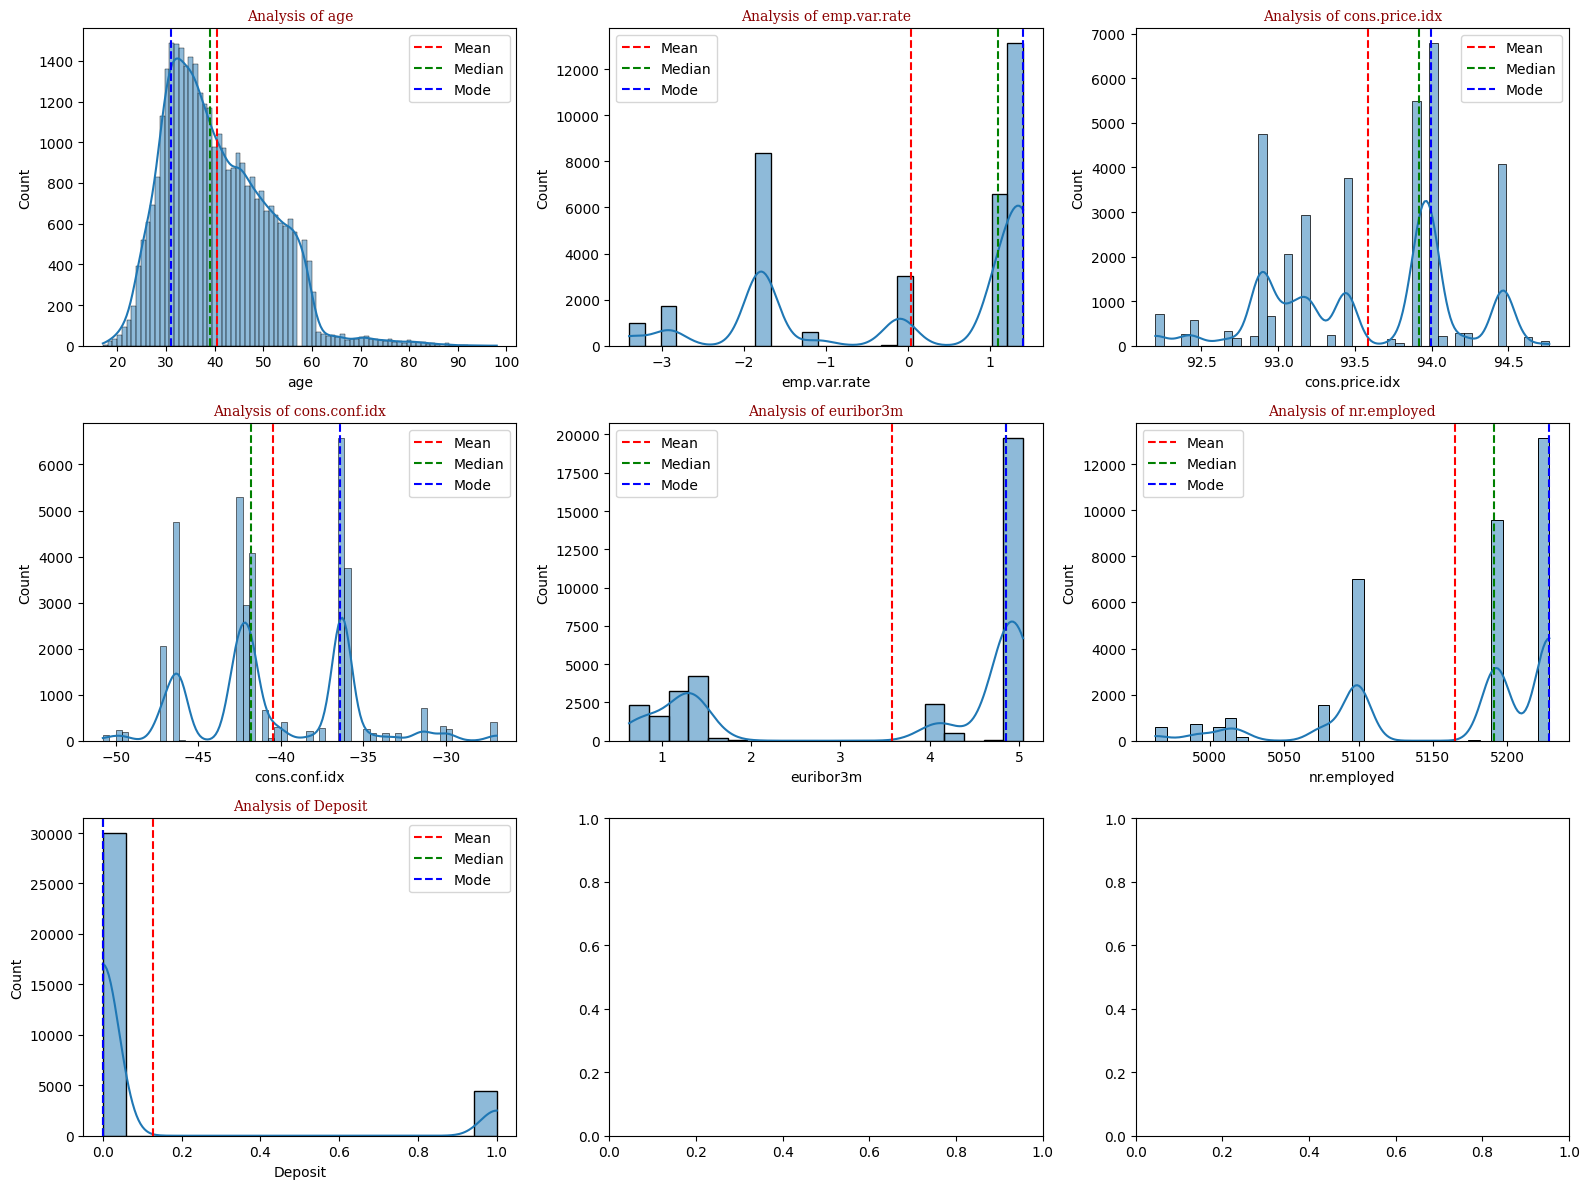

In [10]:
# Plot Distribution for Numerical

def generate_distribution_plot(train_df, continuous_features):
    # create copy of dataframe
    data = train_df[continuous_features].copy()
    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(16,12))
    fig.subplots_adjust(hspace=0.7)

    # set fontdict
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 10,
        }

    # Generate distplot
    for ax, feature in zip(axes.flatten(), data.columns):
        feature_mean = data[feature].mean()
        feature_median = data[feature].median()
        feature_mode = data[feature].mode().values[0]
        sns.histplot(data[feature],ax=ax, kde=True)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
        ax.axvline(feature_mean, color='r', linestyle='--', label="Mean")
        ax.axvline(feature_median, color='g', linestyle='--', label="Median")
        ax.axvline(feature_mode, color='b', linestyle='--', label="Mode")
        ax.legend()
    plt.tight_layout()
    plt.show()

generate_distribution_plot(dfraw, numerical_cols)

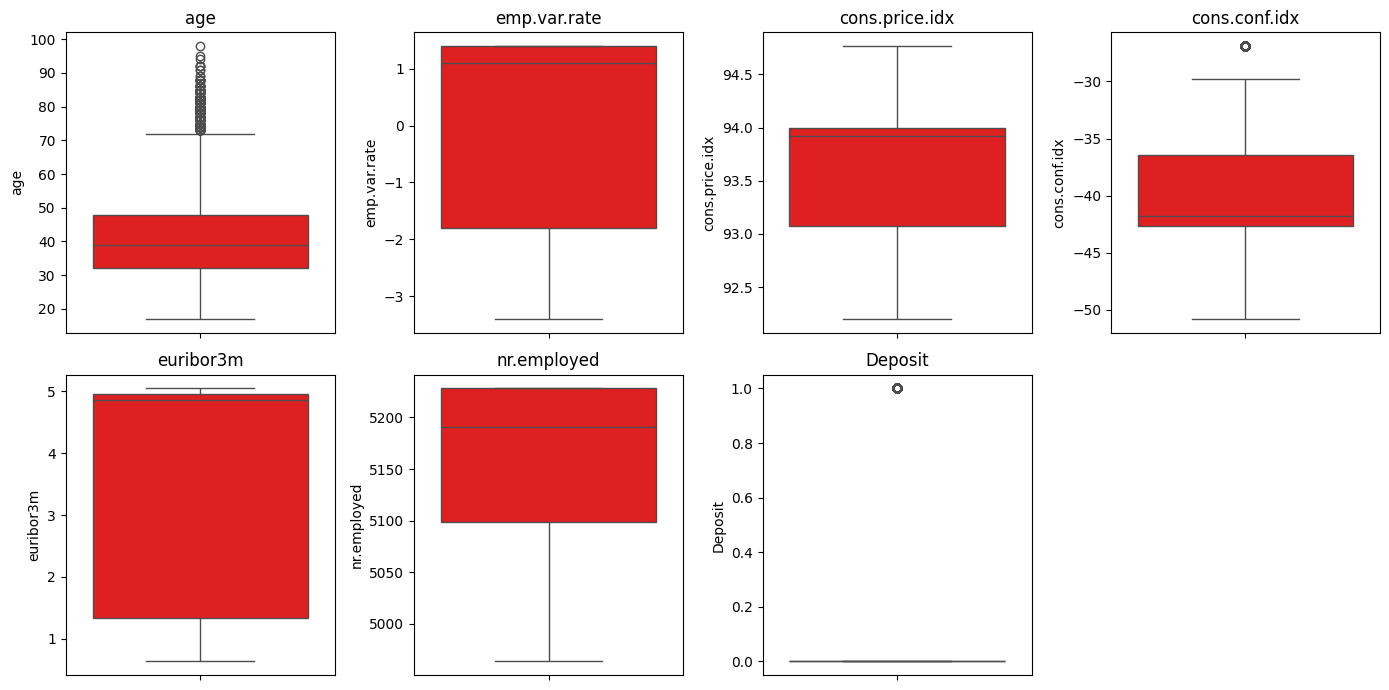

In [11]:
# Boxplot Visualization

plt.figure(figsize=(14, 7))
for i in range(0, len(numerical_cols)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(dfraw[numerical_cols[i]], color='red', orient='v')
    plt.title(numerical_cols[i])
    plt.tight_layout()

In [12]:
# Define Function to Calculate IQR and Outliers
def IQR_outlier(data, col):
    Q1 = data[col].quantile(1/4)
    Q3 = data[col].quantile(3/4)
    IQR = Q3 - Q1
    outlier_lower = Q1 - 1.5 * IQR
    outlier_upper = Q3 + 1.5 * IQR
    total_outliers = len(data[(data[col] < outlier_lower) | (data[col] > outlier_upper)])
    outlier_percentage = round(total_outliers / len(data[col]) * 100, 2)
    return outlier_lower, outlier_upper, total_outliers, outlier_percentage

# Define an Empty List to Store Function Result
outlier = []
for col in numerical_cols:
    lower_band, upper_band, total_outliers, outlier_percentage = IQR_outlier(dfraw, col)
    outlier.append([col, lower_band, upper_band, total_outliers, outlier_percentage])

# Turn the Outliers List Into a Dataframe
outlier_info_df = pd.DataFrame(outlier, columns=["Columns", "Lower Band", "Upper Band", "Total Outliers", "Percentage of Outliers (%)"])
outlier_info_df

,Columns,Lower Band,Upper Band,Total Outliers,Percentage of Outliers (%)
0,age,8.0000,72.0000,306,0.89
1,emp.var.rate,-6.6000,6.2000,0,0.00
2,cons.price.idx,91.6965,95.3725,0,0.00
3,cons.conf.idx,-52.1500,-26.9500,411,1.20
4,euribor3m,-4.1065,10.4015,0,0.00
5,nr.employed,4905.6000,5421.6000,0,0.00
6,Deposit,0.0000,0.0000,4391,12.78


In [13]:
# Outlier Data
display(dfraw[dfraw['age']> 83].describe(), dfraw[dfraw['age']> 83].describe(include='object'))

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,87.259259,-2.098148,93.270759,-38.209259,0.957426,5028.090741,0.462963
std,3.103164,0.798463,0.739927,7.418647,0.332320,49.054130,0.503308
min,84.000000,-3.400000,92.201000,-50.000000,0.635000,4963.600000,0.000000
25%,85.000000,-2.900000,92.713000,-46.200000,0.716000,4991.600000,0.000000
50%,86.000000,-1.800000,93.075000,-37.500000,0.875000,5017.500000,0.000000
75%,88.000000,-1.700000,94.027000,-33.000000,0.998250,5076.200000,1.000000
max,98.000000,-1.100000,94.601000,-26.900000,1.663000,5099.100000,1.000000


,job,marital,education,default,housing,loan
count,54,54,54,54,54,54
unique,2,3,7,2,3,3
top,retired,married,basic.4y,no,yes,no
freq,50,27,35,38,30,44


In [14]:
# Outlier Data
display(dfraw[dfraw['age']<18].describe(), dfraw[dfraw['age']<18].describe(include='object'))

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
count,4.0,4.000,4.0000,4.000,4.000000,4.000,4.00000
mean,17.0,-3.025,92.2585,-30.275,0.841000,5061.525,0.50000
std,0.0,0.250,0.1150,2.250,0.066378,29.350,0.57735
min,17.0,-3.400,92.2010,-31.400,0.742000,5017.500,0.00000
25%,17.0,-3.025,92.2010,-31.400,0.837250,5061.525,0.00000
50%,17.0,-2.900,92.2010,-31.400,0.869000,5076.200,0.50000
75%,17.0,-2.900,92.2585,-30.275,0.872750,5076.200,1.00000
max,17.0,-2.900,92.4310,-26.900,0.884000,5076.200,1.00000


,job,marital,education,default,housing,loan
count,4,4,4,4,4,4
unique,1,1,2,1,3,3
top,student,single,unknown,no,yes,no
freq,4,4,2,4,2,2


In [15]:
# Outlier Data

display(dfraw[dfraw['cons.conf.idx']> -26.95].describe(),dfraw[dfraw['cons.conf.idx']> -26.95].describe(include='object'))

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
count,411.000000,4.110000e+02,4.110000e+02,4.110000e+02,411.000000,411.0,411.000000
mean,45.301703,-3.400000e+00,9.243100e+01,-2.690000e+01,0.735487,5017.5,0.408759
std,17.054331,8.892609e-16,2.845635e-14,3.557044e-15,0.008926,0.0,0.492204
min,17.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.720000,5017.5,0.000000
25%,32.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.728000,5017.5,0.000000
50%,39.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.739000,5017.5,0.000000
75%,59.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.742000,5017.5,1.000000
max,98.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.754000,5017.5,1.000000


,job,marital,education,default,housing,loan
count,411,411,411,411,411,411
unique,12,4,7,2,3,3
top,admin.,married,university.degree,no,yes,no
freq,113,243,150,399,217,346


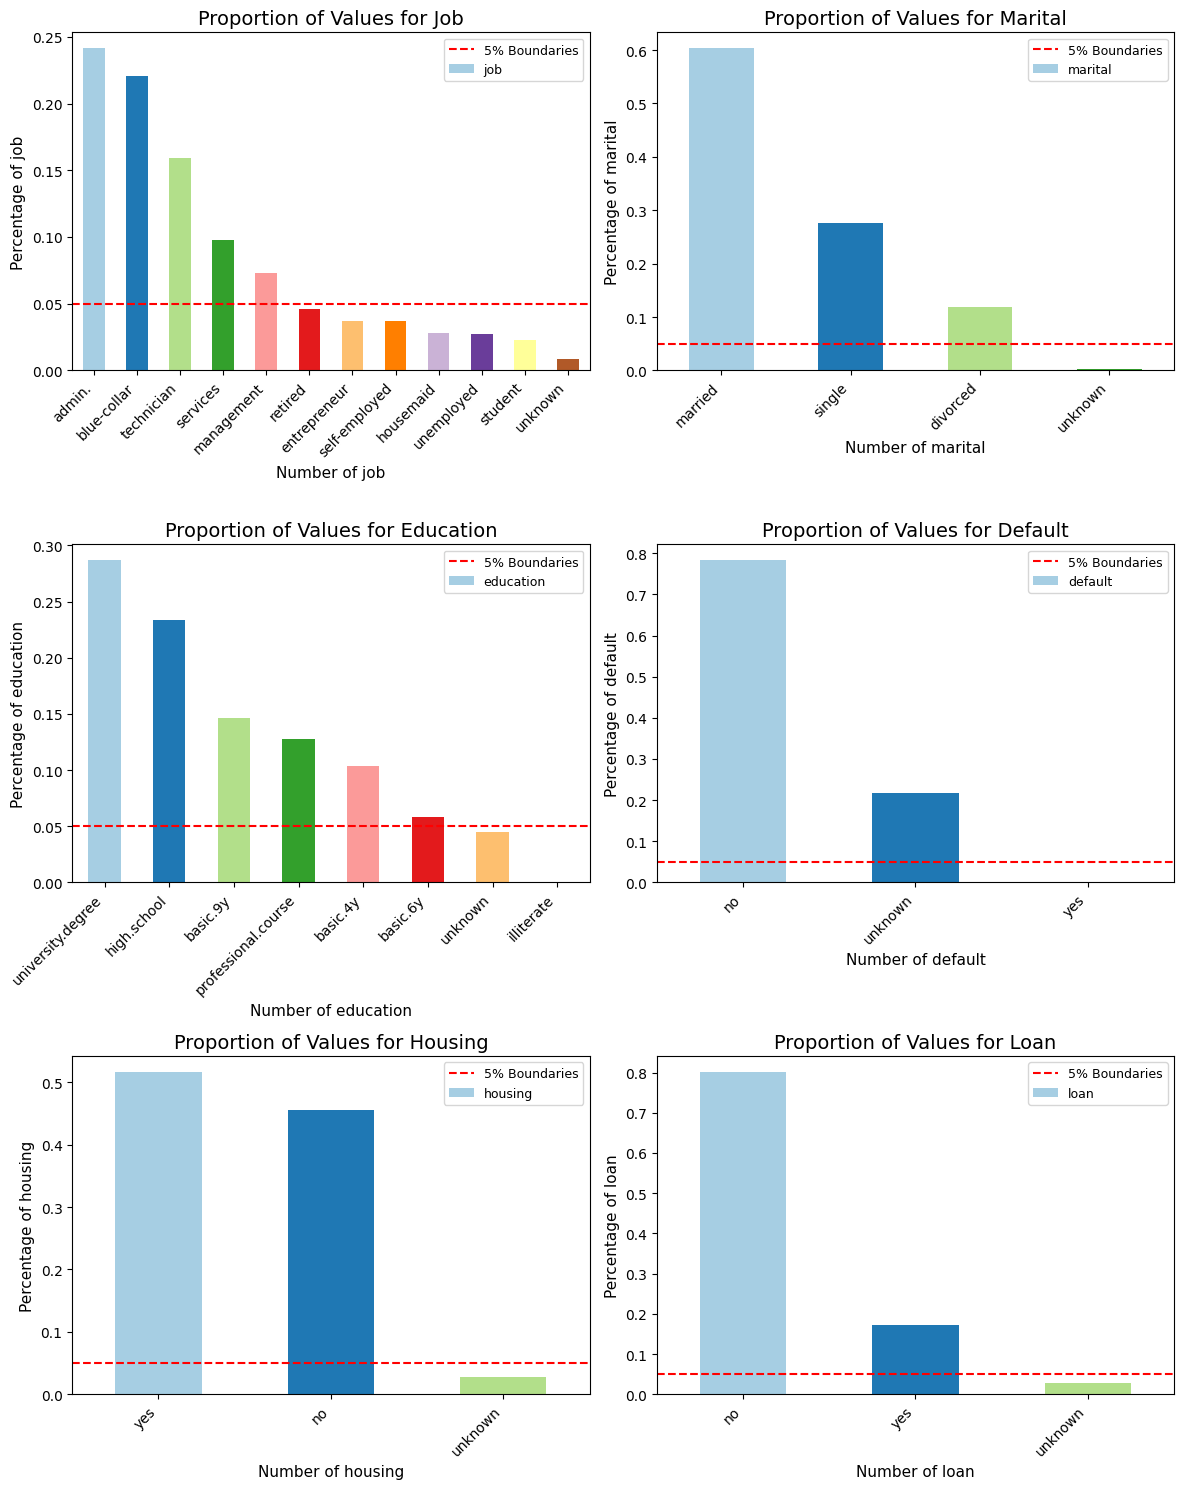

In [16]:
def plot_categorical_proportions(df, columns):

    n_cols = 2
    n_rows = len(columns) // n_cols + (len(columns) % n_cols > 0)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows*5))
    axes = axes.flatten()

    for ax, column in zip(axes, columns):
        # Calculate the value counts and their proportions
        value_counts = df[column].value_counts(normalize=True).sort_values(ascending=False)

        # Create the bar plot
        value_counts.plot(kind='bar', ax=ax, color=sns.color_palette('Paired', len(value_counts)))
        ax.axhline(y=0.05, color='red', linestyle='--', label='5% Boundaries')

        ax.set_title(f'Proportion of Values for {column.capitalize()}', fontsize=14)
        ax.set_xlabel(f'Number of {column}', fontsize=11)
        ax.set_ylabel(f'Percentage of {column}', fontsize=11)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.legend(fontsize=9)

    plt.tight_layout()
    plt.show()

plot_categorical_proportions(dfraw, categorical_cols)

In [17]:
# Calculate Data Who Subscribe and Not Subscribe
target = dfraw['Deposit'].value_counts()

# Calculate Percentage Subscribe and Not Subscribe Term Deposit
percent = (target.values*100/dfraw['Deposit'].count()).round(2)

target_df = pd.DataFrame({
    'Deposit':target.index,
    'Count':target.values,
    '%':percent
}).reset_index(drop=True)
target_df

,Deposit,Count,%
0,0,29957,87.22
1,1,4391,12.78


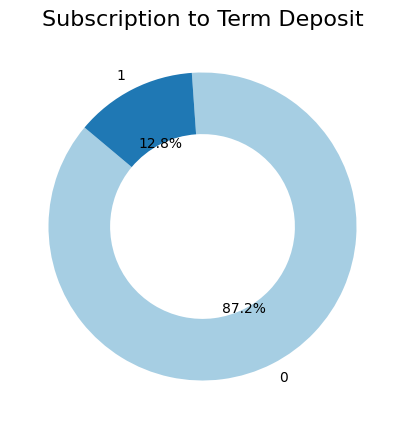

In [18]:
# Plotting Pie Chart
plt.figure(figsize=(5, 5))
colors = sns.color_palette("Paired")[0:len(target_df)]

plt.pie(target_df['Count'], labels=target_df['Deposit'], autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops=dict(width=0.4))

# Enhance the plot
plt.title('Subscription to Term Deposit', fontsize=16)
plt.show()

# **2. Data Cleaning**

In [19]:
# Split the data
df_seen, df_unseen = train_test_split(dfraw, test_size=0.2, random_state=42, stratify=dfraw['Deposit'])
df_seen.shape, df_unseen.shape

((27478, 13), (6870, 13))

In [60]:
df_unseen.to_csv("data unseen model 2.csv", index=False)

#### **2.1. Check Invalid Values**  

**Age Feature**

Based on the literature: Reference of minimum age [for opening account](https://www.movingto.io/pt/bank-accounts-portugal
) is 18 years old and life expectancy in Portugal is 83.

In [20]:
df_seen[(df_seen['age'] < 18) | (df_seen['age'] > 83)].shape

(46, 13)

In [21]:
df_seen = df_seen[(df_seen['age'] >= 18) & (df_seen['age'] <= 83)]
df_seen.shape

(27432, 13)

There are 46 customer data that do not meet the age criteria. Therefore, we will filter data that does not match the criteria and only do modeling for customers with an age range of 18-83 years.

In [22]:
df_seen.describe()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
count,27432.000000,27432.000000,27432.000000,27432.000000,27432.000000,27432.000000,27432.000000
mean,40.367235,0.055439,93.588459,-40.478040,3.592971,5165.318642,0.127369
std,10.442317,1.586733,0.594147,4.645938,1.748857,73.468032,0.333392
min,18.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,39.000000,1.100000,93.918000,-41.800000,4.857000,5191.000000,0.000000
75%,48.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,83.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


#### **2.2. Check Outliers**  

From EDA, we know some features have outliers. But, after cleaning, we should re-check the outliers.

In [23]:
# Define Function to Calculate IQR and Outliers
def IQR_outlier(data, col):
    Q1 = data[col].quantile(1/4)
    Q3 = data[col].quantile(3/4)
    IQR = Q3 - Q1
    outlier_lower = Q1 - 1.5 * IQR
    outlier_upper = Q3 + 1.5 * IQR
    total_outliers = len(data[(data[col] < outlier_lower) | (data[col] > outlier_upper)])
    outlier_percentage = round(total_outliers / len(data[col]) * 100, 2)
    return outlier_lower, outlier_upper, total_outliers, outlier_percentage

# Define an Empty List to Store Function Result
numerical_cols_seen = df_seen.select_dtypes(include=['int64', 'float64']).columns.to_list()
outlier = []
for col in numerical_cols_seen:
    lower_band, upper_band, total_outliers, outlier_percentage = IQR_outlier(df_seen, col)
    outlier.append([col, lower_band, upper_band, total_outliers, outlier_percentage])

# Turn the Outliers List Into a Dataframe
outlier_info_df = pd.DataFrame(outlier, columns=["Columns", "Lower Band", "Upper Band", "Total Outliers", "Percentage of Outliers (%)"])
outlier_info_df

,Columns,Lower Band,Upper Band,Total Outliers,Percentage of Outliers (%)
0,age,8.0000,72.0000,202,0.74
1,emp.var.rate,-6.6000,6.2000,0,0.00
2,cons.price.idx,91.6965,95.3725,0,0.00
3,cons.conf.idx,-52.1500,-26.9500,311,1.13
4,euribor3m,-4.1065,10.4015,0,0.00
5,nr.employed,4905.6000,5421.6000,0,0.00
6,Deposit,0.0000,0.0000,3494,12.74


#### **2.3. Checking Cardinality**

Checking cardinality is a fundamental step before building a classification model. This process helps to understand how a categorical variable is distributed within the dataset, particularly regarding its variability. It's important because a high number of unique values in a column can create challenges for classification models. Additionally, this assessment will guide us in choosing the most appropriate encoding technique for our dataset.

In [24]:
pd.DataFrame({
    'ColumnName': dfraw.columns.values.tolist(),
    'Nrow': dfraw.shape[0],
    'UniqueValue': dfraw.nunique().tolist(),
})

,ColumnName,Nrow,UniqueValue
0,age,34348,78
1,job,34348,12
2,marital,34348,4
3,education,34348,8
4,default,34348,3
5,housing,34348,3
6,loan,34348,3
7,emp.var.rate,34348,10
8,cons.price.idx,34348,26
9,cons.conf.idx,34348,26


Regrouping for `Job` and `Education`

* Job:
    * The categories 'Self-employed' and 'Entrepreneur' will be merged into Self-Employed.
    * 'Housemaid' will be included in the 'Services' category.
    * 'Student', 'Retired', 'Unemployed', and 'Unknown' will all be grouped under 'Unemployed'.
* Education:
    * Based on this [article](https://en.wikipedia.org/wiki/Education_in_Portugal#Secondary_education), all the category is valid and unique, for next process we consider to group category Basic.9y, Basic.4y, and Basic.6y as Basic Education.
    * 'Unknown' and 'Illiterate' will be grouped as "Others".

#### **2.4. Label Ambiguity Checking**  

Label ambiguity means where the data point cannot be annotated as one of the given labels (occurred 2, with 0 and 1 label). 50% of subscribe and 50% of not subscribe might be confusing the model to predict.  
Example :  
Feature combination A : [0,0,1,1,0] => 0  
Feature combination B : [1,1,1,1,0] => 1  
Feature combination C : [0,1] => ?   

We'll try to see how the pattern for each features combination and check the label ambiguity to help model generalize the pattern easier.

In [25]:
def aggregate_labels_indices(group):
    return pd.Series({
        'Instances': len(group),
        'Deposit': list(group['Deposit']),
        'Indices': list(group.index)
    })

In [26]:
# Group by features and aggregate
ambiguous_label = df_seen.groupby(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']).apply(aggregate_labels_indices)

# Filter groups with different labels
ambiguous_label = ambiguous_label[ambiguous_label['Deposit'].apply(lambda x: len(set(x)) > 1)]

ambiguous_label.reset_index(inplace=True)
ambiguous_label.head()

,age,job,marital,education,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Instances,Deposit,Indices
0,19,student,single,unknown,no,yes,no,-1.8,93.075,-47.1,1.405,5099.1,2,"[1, 0]","[28902, 29052]"
1,19,student,single,unknown,no,yes,yes,-1.8,93.075,-47.1,1.405,5099.1,2,"[0, 1]","[29136, 29401]"
2,20,student,single,basic.9y,no,yes,no,-1.8,92.843,-50.0,1.538,5099.1,2,"[0, 1]","[27907, 27904]"
3,20,student,single,high.school,no,no,no,-3.4,92.649,-30.1,0.715,5017.5,2,"[1, 0]","[38747, 38749]"
4,21,student,single,high.school,no,no,no,-2.9,92.963,-40.8,1.260,5076.2,2,"[0, 1]","[36576, 36595]"


In [27]:
# Analyzing the Instances column

average_instances_per_combination = ambiguous_label['Instances'].mean()
most_common_combination = ambiguous_label['Instances'].max()
least_common_combination = ambiguous_label['Instances'].min()

print("Total Combination", len(ambiguous_label))
print("Average Instances per Combination:", average_instances_per_combination)
print("Total Instances for Common Combination:", most_common_combination)
print("Total Instances for Least Common Combination:", least_common_combination)

Total Combination 537
Average Instances per Combination: 2.0
Total Instances for Common Combination: 2
Total Instances for Least Common Combination: 2


In [28]:
# Drop the indexes with ambiguous label and keep it to 1

# Iterate through the inconsistent groups and drop label 0 instances from the original dataframe
for _, group in ambiguous_label.iterrows():
    indices_to_drop = group['Indices'][group['Deposit'] == 0]
    df_seen.drop(index=indices_to_drop, inplace=True)

In [29]:
df_seen.shape

(26895, 13)

#### **2.5. Pipelining**

Creating the pipeline for data cleaning process.

In [30]:
groups = {
    # Job dict
    'admin.': 'admin',
    'entrepreneur': 'self-employed',
    'housemaid': 'services',
    'retired': 'unemployed',
    'unknown': 'unemployed',

    # Education dict
    'basic.9y': 'basic',
    'basic.4y': 'basic',
    'basic.6y': 'basic',
    'high.school': 'high school',
    'unknown': 'others',
    'illiterate':'others',
    'university.degree': 'university',
    'professional.course': 'professional'
}

In [31]:
# Define ColumnTransformer
cleaner = ColumnTransformer(
    transformers=[
        ('regrouping', ValueConverter(mapping_dict=groups), ['Education', 'Job']),
        ('binning', KBinsDiscretizer(encode='ordinal', strategy='quantile'), ['Age', 'ConsConf_Idx'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

cleaner

ColumnTransformer(remainder='passthrough',
                  transformers=[('regrouping',
                                 ValueConverter(mapping_dict={'admin.': 'admin',
                                                              'basic.4y': 'basic',
                                                              'basic.6y': 'basic',
                                                              'basic.9y': 'basic',
                                                              'entrepreneur': 'self-employed',
                                                              'high.school': 'high '
                                                                             'school',
                                                              'housemaid': 'services',
                                                              'illiterate': 'others',
                                                              'professional.course': 'professional',
                                                              'retired': 'unemployed',
                                                              'university.degree': 'university',
                                                              'unknown': 'others'}),
                                 ['Education', 'Job']),
                                ('binning', KBinsDiscretizer(encode='ordinal'),
                                 ['Age', 'ConsConf_Idx'])],
                  verbose_feature_names_out=False)

---
---

# **3. Feature Engineering**

---
---

### **3.1. Feature Selection**

**Power Predictive Score** (PPS) is a metric used to measure the predictive power of a feature with respect to the target variable in a dataset. It helps in evaluating how well a feature can predict the target variable. By evaluating PPS, we can select features that have higher predictive power, thus improving the performance and interpretability of our model.

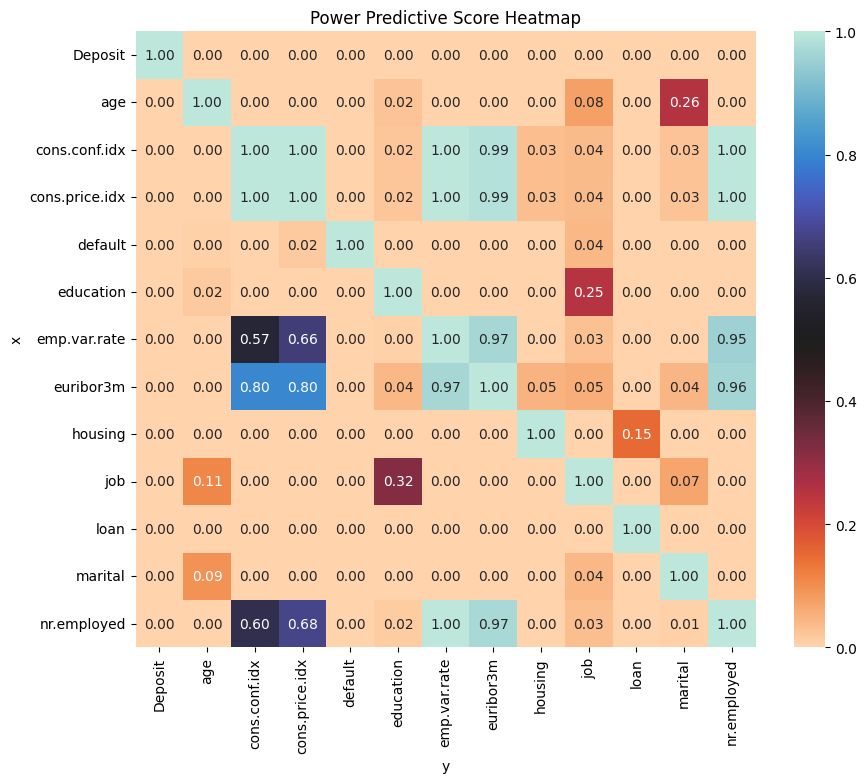

In [32]:
# Calculate the PPS matrix
pps_matrix = pps.matrix(df_seen)

# Pivot the PPS matrix to a format suitable for heatmap
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')

# Show
plt.figure(figsize=(10,8))
sns.heatmap(pps_pivot, annot=True, fmt=".2f", cmap='icefire_r')
plt.title('Power Predictive Score Heatmap')
plt.show()

Summary :  
Even if features are highly correlated, if their PPS scores with the target variable are low, it implies that while the features are related to each other, they might not be useful in predicting the target variable, and it suggests redundancy. Including redundant features can lead to overfitting and may not improve model performance.  

Handling :  
So, we will remove features that are highly correlated with others or redundant features.

In [33]:
# Drop Redundant Features
selector = ColumnTransformer(
    transformers=[
        ('feature_select', 'drop', ['ConsPrice_Idx','Euribor3M_Rate', 'EmpVar_Rate','Marital']),
    ],
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

selector

ColumnTransformer(remainder='passthrough',
                  transformers=[('feature_select', 'drop',
                                 ['ConsPrice_Idx', 'Euribor3M_Rate',
                                  'EmpVar_Rate', 'Marital'])],
                  verbose_feature_names_out=False)

### **3.2. Feature Encoding**  

In [34]:
# Pipelining
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe_encode', OneHotEncoder(drop='first',handle_unknown='ignore'), ['Job', 'Education', 'Housing_Loan', 'Personal_Loan', 'Credit_Default']),
    ],
    remainder='passthrough', verbose_feature_names_out=False)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Job', 'Education', 'Housing_Loan',
                                  'Personal_Loan', 'Credit_Default'])],
                  verbose_feature_names_out=False)

## **3.3. Pipelining**

In [35]:
# Renaming the features for better comprehension
rename_dict = {'age':'Age',
               'job':'Job',
               'marital':'Marital',
               'education':'Education',
               'default':'Credit_Default',
               'housing':'Housing_Loan',
               'loan':'Personal_Loan',
               'emp.var.rate':'EmpVar_Rate',
               'cons.price.idx':'ConsPrice_Idx',
               'cons.conf.idx':'ConsConf_Idx',
               'euribor3m':'Euribor3M_Rate',
               'nr.employed':'Qty_Employee',
}

# Define the preprocessing pipeline
base_pipeline = Pipeline(steps=[
    ('rename', ColumnRenamer(rename_dict=rename_dict)),
    ('data_cleaning', cleaner),
    ('feature selection', selector),
    ('feature transformation', preprocessor)
])
base_pipeline

Pipeline(steps=[('rename',
                 ColumnRenamer(rename_dict={'age': 'Age',
                                            'cons.conf.idx': 'ConsConf_Idx',
                                            'cons.price.idx': 'ConsPrice_Idx',
                                            'default': 'Credit_Default',
                                            'education': 'Education',
                                            'emp.var.rate': 'EmpVar_Rate',
                                            'euribor3m': 'Euribor3M_Rate',
                                            'housing': 'Housing_Loan',
                                            'job': 'Job',
                                            'loan': 'Personal_Loan',
                                            'marital': 'Marital',
                                            'nr.employed': 'Qty_Employee'})),...
                                   transformers=[('feature_select', 'drop',
                                                  ['ConsPrice_Idx',
                                                   'Euribor3M_Rate',
                                                   'EmpVar_Rate', 'Marital'])],
                                   verbose_feature_names_out=False)),
                ('feature transformation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Job', 'Education',
                                                   'Housing_Loan',
                                                   'Personal_Loan',
                                                   'Credit_Default'])],
                                   verbose_feature_names_out=False))])

---
---

# **4. Modeling Exp**

---
---

In [36]:
df_seen.describe()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Deposit
count,26895.000000,26895.000000,26895.000000,26895.000000,26895.000000,26895.000000,26895.000000
mean,40.411340,0.068570,93.593256,-40.467648,3.608032,5165.882882,0.119911
std,10.417207,1.580903,0.593531,4.624570,1.743300,73.158799,0.324863
min,18.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,39.000000,1.100000,93.918000,-41.800000,4.857000,5191.000000,0.000000
75%,48.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,83.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [37]:
# Split X and y in data train
X_train = df_seen.drop(columns='Deposit')
y_train = df_seen.Deposit

# Split X and y in data test
X_test = df_unseen.drop(columns='Deposit')
y_test = df_unseen.Deposit

## **4.0. Model-Business Explanation**

In [38]:
# Historical data - Without Modeling

total_customers = len(dfraw)
total_deposit_subscriptions = len(dfraw[dfraw['Deposit'] == 1])
total_non_subscriptions = len(dfraw[dfraw['Deposit'] == 0])
deposit = 500
tele_cost = 23

# Conversion rate and Revenue
conversion_rate = total_deposit_subscriptions / total_customers * 100
possible_revenue = total_customers * deposit

# ROAS (Revenue On Ad Spend)
total_revenue = total_deposit_subscriptions * deposit
total_tele_cost = total_customers * tele_cost
romi = (total_revenue-total_tele_cost)/total_tele_cost * 100

print("Historical Total Customers is: ", total_customers)
print("Historical Total Deposit Subscriptions is: ", total_deposit_subscriptions)
print("Historical Conversion Rate is: ", round(conversion_rate, 2), "(%)")
print("Historical Total Telemarketing Cost: EUR", round(total_tele_cost, 2))

Historical Total Customers is:  34348
Historical Total Deposit Subscriptions is:  4391
Historical Conversion Rate is:  12.78 (%)
Historical Total Telemarketing Cost: EUR 790004


In [39]:
# Prediction Data

total_unseen_customers = len(df_unseen)
total_unseen_deposit_subscriptions = len(df_unseen[df_unseen['Deposit'] == 1])
total_unseen_non_subscriptions = len(df_unseen[df_unseen['Deposit'] == 0])
deposit = 500
tele_cost = 23

# Conversion rate and Revenue
cvr_unseen = total_unseen_deposit_subscriptions / total_unseen_customers * 100
total_tele_cost_unseen = total_unseen_customers * tele_cost

print("Unseen - Total Customers is: ", total_unseen_customers)
print("Unseen - Conversion Rate is: ", round(cvr_unseen, 2), "(%)")
print("Unseen - Total Telemarketing Cost: EUR", round(total_tele_cost_unseen, 2))

Unseen - Total Customers is:  6870
Unseen - Conversion Rate is:  12.78 (%)
Unseen - Total Telemarketing Cost: EUR 158010


We've calculated the data from historical and unseen sources. Since we split the data with the same proportion of deposit subscription status, the Conversion Rate is still the same. 
We will do modeling to see which model can give us the highest Recall score where we focus on True actual outcomes.

**List of Models**

In [43]:
list_models = [
    ('KNN', KNeighborsClassifier()),
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

In [44]:
def evaluate_models(models, X_train, X_test, y_train, y_test, experiment_pipeline=None):
    results = defaultdict(list)

    for model_name, model in models:
        # Combine preprocessing pipeline with the experiment pipeline (if provided)
        if experiment_pipeline:
            # Extract steps from base_pipeline end experiment pipeline
            base_steps = base_pipeline.steps
            experiment_steps = experiment_pipeline.steps

            # Combine all steps
            all_steps = base_steps + experiment_steps + [('classifier', model)]
            full_pipeline = ImbPipeline(steps=all_steps)
        else:
            full_pipeline = Pipeline(steps=[
                ('preprocessing', base_pipeline),
                ('classifier', model)
            ])

        # Fit and predict
        full_pipeline.fit(X_train, y_train)
        y_pred_train = full_pipeline.predict(X_train)
        y_pred_test = full_pipeline.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test)
        recall_train = recall_score(y_train, y_pred_train)
        recall_test = recall_score(y_test, y_pred_test)
        f1score = f1_score(y_test, y_pred_test)

        # Cross-validated precision for the training set
        stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_train_cv = cross_val_predict(full_pipeline, X_train, y_train, cv=stratified_cv)
        recall_train_cv = recall_score(y_train, y_pred_train_cv)
        recall_diff = abs(recall_train_cv - recall_test)

        results['Model'].append(model_name)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        results['Recall Train'].append(recall_train_cv)
        results['Recall Test'].append(recall_test)
        results['Recall Difference'].append(recall_diff)
        results['F1 Score'].append(f1score)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Recall Difference')

    # Highlighting the highest values
    result_df = results_df.style.highlight_max(subset=['Accuracy', 'Recall Train', 'Recall Test', 'Precision', 'F1 Score'], color='lightgreen')\
                               .highlight_min(subset=['Recall Difference'], color='lightgreen')

    return result_df


### <b>4.1.1. Experiment 0: Baseline

In [45]:
# Display the Result
base_results = evaluate_models(list_models, X_train, X_test, y_train, y_test, experiment_pipeline=None)
base_results

,Model,Accuracy,Precision,Recall Train,Recall Test,Recall Difference,F1 Score
0,KNN,0.864047,0.441423,0.235969,0.240319,0.004350,0.311209
4,XGBoost,0.869723,0.477922,0.204341,0.209567,0.005226,0.291370
7,Gradient Boosting,0.875400,0.541045,0.157519,0.165148,0.007629,0.253054
6,AdaBoost,0.871907,0.496644,0.156589,0.168565,0.011976,0.251701
5,Naive Bayes,0.744250,0.279478,0.620465,0.634396,0.013931,0.388018
3,Random Forest,0.786608,0.296961,0.462636,0.489749,0.027114,0.369733
2,Decision Tree,0.735517,0.254060,0.523411,0.552392,0.028981,0.348044
1,Logistic Regression,0.455895,0.158711,0.673488,0.757403,0.083915,0.262431


### **4.1.2. Experiment 1: SMOTE**

**Purpose**: SMOTE is used to oversample the minority class by generating synthetic examples rather than by duplicating existing examples. This helps in balancing the class distribution and preventing the model from being biased towards the majority class.

**How It Works**: SMOTE works by creating synthetic samples from the minority class that are similar to existing samples, thereby increasing the representation of the minority class.

In [46]:
exp1 = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
])

results_exp1 = evaluate_models(list_models, X_train, X_test, y_train, y_test, experiment_pipeline=exp1)
results_exp1

,Model,Accuracy,Precision,Recall Train,Recall Test,Recall Difference,F1 Score
0,KNN,0.843523,0.376721,0.344496,0.342825,0.001672,0.358974
5,Naive Bayes,0.364047,0.149146,0.841860,0.845103,0.003242,0.253545
6,AdaBoost,0.822562,0.375457,0.571473,0.585421,0.013949,0.457499
7,Gradient Boosting,0.829549,0.388083,0.564031,0.578588,0.014557,0.464563
1,Logistic Regression,0.462154,0.157549,0.713798,0.738041,0.024243,0.259667
3,Random Forest,0.812809,0.316876,0.369922,0.402050,0.032128,0.354418
2,Decision Tree,0.816885,0.312992,0.326202,0.362187,0.035985,0.335797
4,XGBoost,0.836681,0.386406,0.434729,0.472665,0.037936,0.425205


### **4.1.3. Experiment 2:** TomekLinks


**Purpose**: Tomek links are used to undersample the majority class by identifying pairs of instances (one from each class) that are closest to each other. By removing the majority class instance of each pair, Tomek links aim to increase the margin between classes.

**How It Works**: Tomek links algorithmically identifies pairs of instances—one from the majority class and one from the minority class—that are closest to each other. It then removes the majority class instance of each pair, which helps in cleaning up the overlap and improving the separation between classes.

In [47]:
exp2 = ImbPipeline(steps=[
    ('tomek', TomekLinks(sampling_strategy = 'majority')),
])

results_exp2 =  evaluate_models(list_models, X_train, X_test, y_train, y_test, experiment_pipeline=exp2)
results_exp2

,Model,Accuracy,Precision,Recall Train,Recall Test,Recall Difference,F1 Score
7,Gradient Boosting,0.875109,0.535211,0.170233,0.173121,0.002888,0.261618
0,KNN,0.864192,0.442589,0.238140,0.241458,0.003318,0.312454
4,XGBoost,0.867686,0.461538,0.205581,0.211845,0.006264,0.290398
5,Naive Bayes,0.745997,0.280728,0.618605,0.632118,0.013514,0.388792
6,AdaBoost,0.872780,0.506494,0.160310,0.177677,0.017366,0.263069
2,Decision Tree,0.737118,0.255274,0.529302,0.551253,0.021951,0.348955
3,Random Forest,0.784571,0.296896,0.470388,0.501139,0.030751,0.372881
1,Logistic Regression,0.564483,0.175568,0.696744,0.651481,0.045264,0.276596


### **4.1.4. Experiment 3: NearMiss**  
**Purpose** :  
NearMiss is designed to reduce the number of instances in the majority class so that the class distribution is more balanced, which can improve the performance of classifiers on imbalanced datasets.

**How It Works**:  
NearMiss works by selecting samples from the majority class based on their distance to the minority class samples using k-nearest.

In [48]:
exp3 = ImbPipeline(steps=[
    ('nearmiss', NearMiss(version=3)),
])

results_exp3 =  evaluate_models(list_models, X_train, X_test, y_train, y_test, experiment_pipeline=exp3)
results_exp3

,Model,Accuracy,Precision,Recall Train,Recall Test,Recall Difference,F1 Score
6,AdaBoost,0.748763,0.285208,0.630698,0.641230,0.010532,0.394811
4,XGBoost,0.672780,0.207515,0.569302,0.553531,0.015772,0.301863
2,Decision Tree,0.676856,0.184384,0.427287,0.446469,0.019182,0.260985
7,Gradient Boosting,0.758079,0.293901,0.617364,0.636674,0.019310,0.402158
5,Naive Bayes,0.479767,0.169931,0.768682,0.790433,0.021751,0.279726
3,Random Forest,0.670306,0.195165,0.479070,0.505695,0.026625,0.281637
1,Logistic Regression,0.502329,0.159292,0.646512,0.676538,0.030026,0.257868
0,KNN,0.790102,0.248663,0.359690,0.317768,0.041922,0.279000


**Results from experiments**
________________

| Exp | Best Model | Recall |
| --- | --- | --- |
| Baseline | Logistic Regression | 0.68 |
| + SMOTE | Naive Bayes | 0.84 |
| + TomekLinks | Logistic Regression | 0.65 |
| + NearMiss | Naive Bayes | 0.77 |  


From all experiments, we know that Naive Bayes with SMOTE has the highest Recall score. So, **we choose Naive Bayes with SMOTE as our final model**.

## **4.2. Final Model**

In [49]:
# Define the final model pipeline
final_model_pipeline = ImbPipeline(steps=[
    ('rename', ColumnRenamer(rename_dict=rename_dict)),
    ('data_cleaning', cleaner),
    ('feature selection', selector),
    ('feature transformation', preprocessor),               # Apply the base preprocessing pipeline
    ('smote', SMOTE(random_state=42)),                      # Apply SMOTE for balancing
    ('classifier', GaussianNB())                            # Gaussian Naive Bayes for classification
])

# Fit the pipeline on the training data
final_model_pipeline.fit(X_train, y_train)

# Evaluate the model using cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model_pipeline, X_train, y_train, cv=stratified_cv, scoring='recall')

# Predict on the test data
y_pred_test_nb = final_model_pipeline.predict(X_test)

# Calculate test metrics
accuracy_nb = accuracy_score(y_test, y_pred_test_nb)
precision_nb = precision_score(y_test, y_pred_test_nb)
recall_nb = recall_score(y_test, y_pred_test_nb)
f1score_nb = f1_score(y_test, y_pred_test_nb)

print("Evaluation Metrics for Naive Bayes")
eval_model_nb = {
    "Metric": ["Accuracy", "Precision", "Recall","F1 Score"],
    "Value": [accuracy_nb, precision_nb, recall_nb, f1score_nb]
}

# Create DataFrame
df_model_nb = pd.DataFrame(eval_model_nb)
df_model_nb

Evaluation Metrics for Naive Bayes


,Metric,Value
0,Accuracy,0.364047
1,Precision,0.149146
2,Recall,0.845103
3,F1 Score,0.253545


In [50]:
final_model_pipeline

Pipeline(steps=[('rename',
                 ColumnRenamer(rename_dict={'age': 'Age',
                                            'cons.conf.idx': 'ConsConf_Idx',
                                            'cons.price.idx': 'ConsPrice_Idx',
                                            'default': 'Credit_Default',
                                            'education': 'Education',
                                            'emp.var.rate': 'EmpVar_Rate',
                                            'euribor3m': 'Euribor3M_Rate',
                                            'housing': 'Housing_Loan',
                                            'job': 'Job',
                                            'loan': 'Personal_Loan',
                                            'marital': 'Marital',
                                            'nr.employed': 'Qty_Employee'})),...
                                                   'EmpVar_Rate', 'Marital'])],
                                   verbose_feature_names_out=False)),
                ('feature transformation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Job', 'Education',
                                                   'Housing_Loan',
                                                   'Personal_Loan',
                                                   'Credit_Default'])],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42)),
                ('classifier', GaussianNB())])

## <b>4.3. Model Evaluation

### **4.3.1. Classification Report**
A classification report is a summary showing how well a classification model performs.

In [51]:
# Print the classification report

print("\nClassification Report for Naive Bayes:\n")
print(classification_report(y_test, y_pred_test_nb))


Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.93      0.29      0.45      5992
           1       0.15      0.85      0.25       878

    accuracy                           0.36      6870
   macro avg       0.54      0.57      0.35      6870
weighted avg       0.83      0.36      0.42      6870



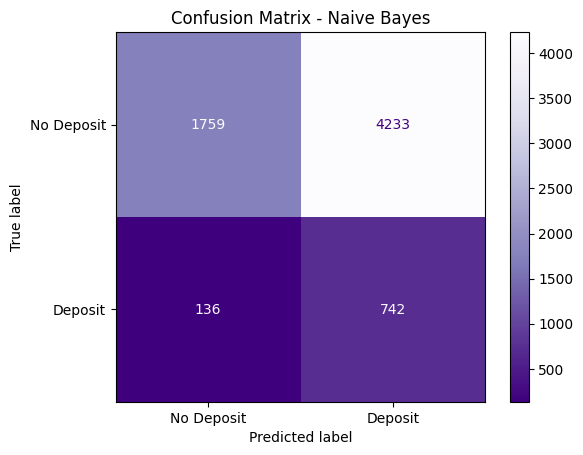

In [52]:
cm = confusion_matrix(y_test, y_pred_test_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Purples_r)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

### **4.3.2. Learning Curve**


A learning curve evaluates how well a machine learning model performs as it learns from more data or is trained longer.






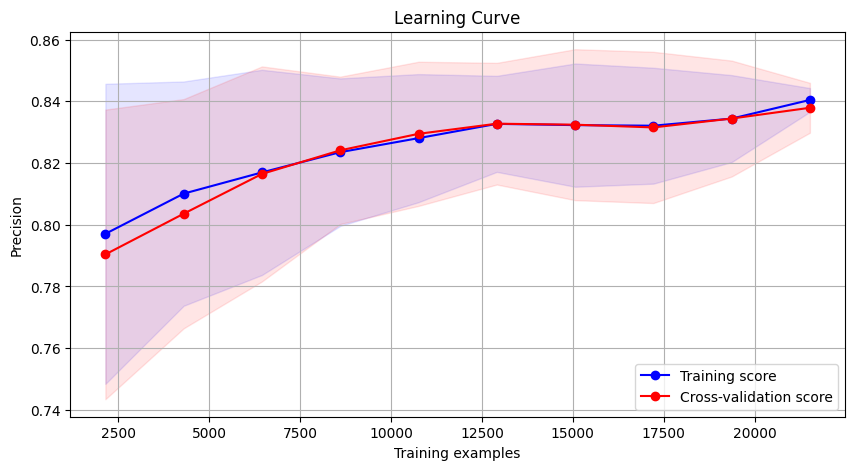

In [53]:
# Create learning curve
train_sizes, train_scores, test_scores = \
    learning_curve(final_model_pipeline, X_train, y_train, cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
                   train_sizes=np.linspace(0.1, 1.0, 10), scoring='recall', n_jobs=-1)

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Precision")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [54]:
pd.DataFrame({'TrainingScoreMean':train_scores_mean,
              'TrainingScoreSD':train_scores_std,
              'TestScoreMean': test_scores_mean,
              'TestScoreSD':test_scores_std}).round(2)

,TrainingScoreMean,TrainingScoreSD,TestScoreMean,TestScoreSD
0,0.80,0.05,0.79,0.05
1,0.81,0.04,0.80,0.04
2,0.82,0.03,0.82,0.03
3,0.82,0.02,0.82,0.02
4,0.83,0.02,0.83,0.02
5,0.83,0.02,0.83,0.02
6,0.83,0.02,0.83,0.02
7,0.83,0.02,0.83,0.02
8,0.83,0.01,0.83,0.02
9,0.84,0.00,0.84,0.01


### **4.3.3. Reliability Curve**  

A calibration curve in the context of machine learning and classification tasks is a graphical tool used to assess how well probabilistic predictions from a classification model align with the actual outcomes or frequencies of those predictions. It helps to evaluate whether the predicted probabilities reflect the true likelihood of a positive outcome (in this case:deposit being subscribed).

For example, if our model predicts a probability of 0.8 for a certain event, we would expect that event to occur approximately 80% of the time when the model makes such predictions. The calibration curve visually compares these predicted probabilities against the actual frequencies, providing insights into the reliability and accuracy of the model's probabilistic forecasts.

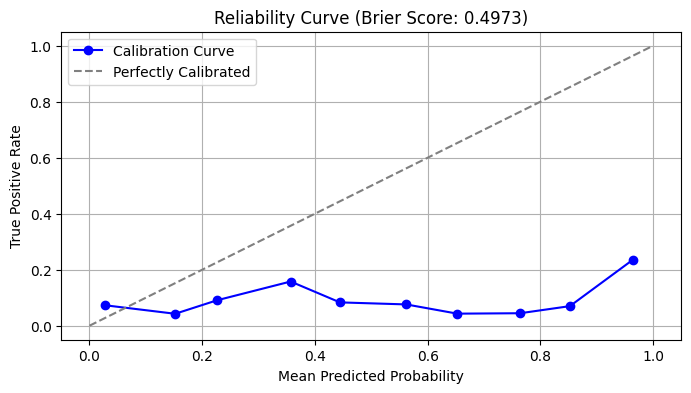

Brier Score: 0.49732671175907367


In [55]:
# Predict probabilities on the test set
probabilities = final_model_pipeline.predict_proba(X_test)[:, 1]

# Compute calibration curve
true_prob, predicted_prob = calibration_curve(y_test, probabilities, n_bins=10)
# Calculate Brier score
brier = brier_score_loss(y_test, probabilities)

# Plot calibration curve
plt.figure(figsize=(8, 4))
plt.plot(predicted_prob, true_prob, marker='o', linestyle='-', color='blue', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Positive Rate')
plt.title('Reliability Curve (Brier Score: {:.4f})'.format(brier))
plt.legend()
plt.grid(True)
plt.show()

print('Brier Score:', brier)

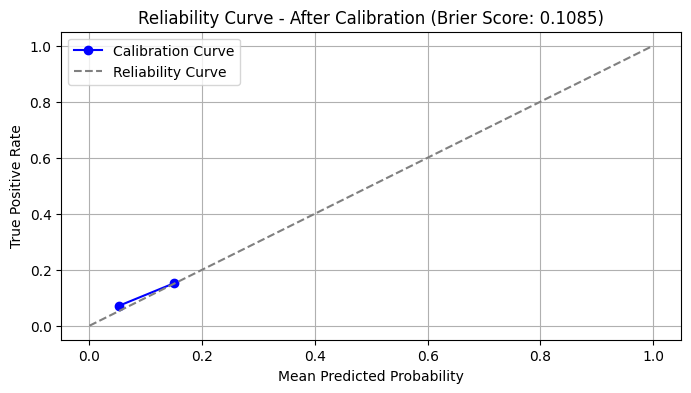

Calibrated Brier Score: 0.10852199449456085


In [56]:
# Fit and calibrate
calibrated_model = CalibratedClassifierCV(final_model_pipeline, method='sigmoid', cv=stratified_cv)
calibrated_model.fit(X_train, y_train)

# Predict probabilities
y_prob = calibrated_model.predict_proba(X_test)[:, 1]

# Plot calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
calibrated_brier_score = brier_score_loss(y_test, y_prob)

# Plot calibration curve
plt.figure(figsize=(8, 4))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='blue', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Reliability Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Positive Rate')
plt.title('Reliability Curve - After Calibration (Brier Score: {:.4f})'.format(calibrated_brier_score))
plt.legend()
plt.grid(True)
plt.show()

print(f'Calibrated Brier Score: {calibrated_brier_score}')

The Brier score, named after Glenn Brier, is a metric used to evaluate the accuracy of probabilistic predictions made by a classification model. It measures the mean squared difference between predicted probabilities (of the positive class, for example) and the actual outcomes (binary labels). Before calibration, the Brier Score seems large, almost 0.5, but after calibration, the brier score get lower indicates better performance.

### **4.3.4. Business Simulation**  


**1. Scenario without Modeling**

In this scenario our bank will give campaign to all customers, that is 6,870 unseen data with conversion rate 12.78%. Here is the cost revenue calculation :

Conversion Rate = 12.78%
<br>Total telemarketing cost = 6,870 x EUR 23 = EUR 158,010


**2. Scenario with Modeling**

After we do modeling, we can calculate telemarketing cost and conversion rate unseen data based on the confusion matrix. The conversion rate will be calculated for all true positives among the positive actual outcomes to ensure we can get all positive actual customers.

TP (Predict Deposit, Actual Deposit) : 742
<br>FP (Predict Deposit, Actual No Deposit) : 4230
<br>FN (Predict No Deposit, Actual Deposit) : 136
<br>TN (Predict No Deposit, Actual No Deposit) :  1,762

We will give campaign only to customers who are out as actual positive (TP and FN) :

Total deposit subscription = 742 + 136   
Conversion Rate = 742/(742+136) * 100 = 84.5 %
<br>Total telemarketing cost = (742 + 136) x EUR 23 = EUR 20,194


**3. Comparison:**

* **Without modeling:**  
  CVR  : 12.78%  
  Telemarketing Cost : EUR 158,010

* **With modeling**:  
  CVR  : 84.5%  
  Telemarketing Cost : EUR 20,194

* **Impact of modeling:**  
  **1. Conversion Rate increased by 6.61 times**.

  **2. Telemarketing cost decreased by 7.82 times**.

## <b>4.4. Best Model Explanation

### **4.4.1. How Final Model Works**

Naive Bayes is a classification algorithm that predicts the category of a data point based on its features. This model use Bayes theorem, which calculates the probability that a data point belongs to a certain class by its features. It assumes that all features contribute independently to the final classification, which is why it’s called "naive".

The process involves :
1. **Calculate Data Proportion:** The model first calculates the proportion of data points in each target class. In our case, it calculate how many data Deposit and No Deposit.
2. **Calculate Feature Probabilities:** The model calculates the probability of observing a particular feature value in target class for each features.
3. **Apply Bayes Theorem:** The model combines the data proportions and feature probabilities to calculate the overall probability that a data point belongs to each target class.
4. **Make a Prediction:** The model predicts the target class with the highest overall probability as the final classification.

### <b>4.4.2. Global Explanation: Permutation Importance

Permutation importance is a model-agnostic technique used to evaluate the importance of individual features in a machine learning model. The basic idea is to measure how the model's performance changes when the values of a single feature are randomly shuffled. By shuffling, the association between that feature and the target variable is broken, and the decrease in the model's performance (e.g. Recall) indicates how much the model relies on that feature for predictions.

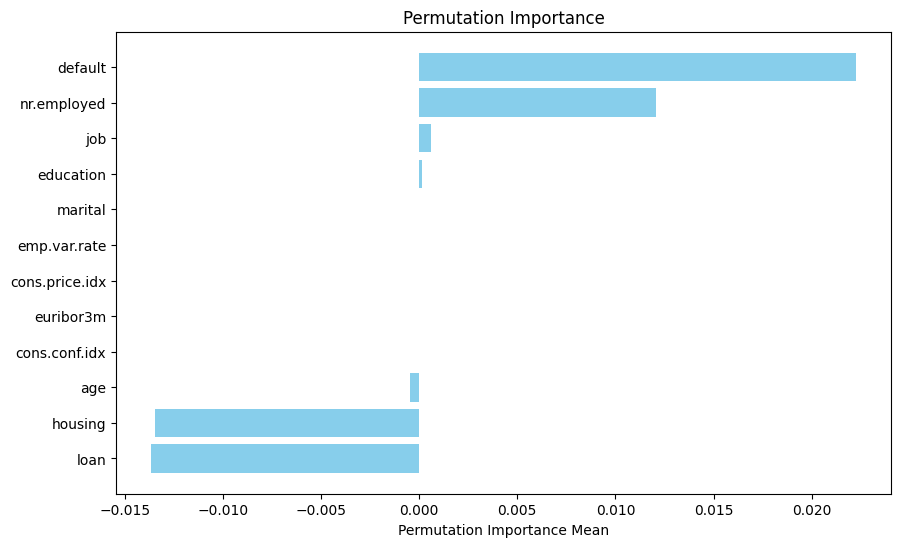

In [57]:
# Fit model
final_model_pipeline.fit(X_train, y_train)

# Compute permutation importance
perm_importance = permutation_importance(final_model_pipeline, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importance
perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': perm_importance.importances_mean,
})

# Sort by importance mean
perm_importance_df = perm_importance_df.sort_values(by='Importance Mean', ascending=False)

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance Mean'], color='skyblue')
plt.xlabel('Permutation Importance Mean')
plt.title('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

**Key Insight**:  

* Credit default and quantity of employee show the highest permutation importance, indicating that these features are crucial for the model's predictions. Shuffling these features results in a significant drop in the model's performance, showing their strong influence.
* Housing loan, personal loan, and age also contribute to the model, though to a lesser extent compared to default and nr.employed. 
* Other features like job, education, marital, and economic indicators (emp.var.rate, cons.price.idx, euribor3m) show minimal or no importance. This indicates that the model's performance isn't heavily dependent on these features.

### <b>4.4.3. Final Model Saving

In [58]:
# Save the model
with open('gaussian-nb-model.pkl', 'wb') as file:
    pickle.dump(final_model_pipeline, file)

# **5. Conclusions and Recommendations**

-------------
-------------

## **5.1. Conclusions**

This model is developed to handle scenario where Electric Bank receives new customer data who have never been contacted and given any campaign before. The best model, Gaussian Naive Bayes classifier with SMOTE oversampling technique, achieves recall score of 0.845.

The high recall score indicates that the model is effective to identify customers who are actually subscribe to term deposit. 

**By implementing this model, Electric Bank can potentially increase conversion rate by 6.61 times and reduce telemarketing cost by 7.82 times.**

##  **5.2. Model Limitation**

1. The model's predictions are having limitations by the range of observed data :
    - Customer's age between 18 - 83 years old.
    - Consumer confidence index ranges between -50.8 to -26.9.
    - Number of employees between 4963 - 5228.

2. The model's predictions may be less accurate for customers with features outside the observed ranges.
4. The model only considers the features provided in dataset. Other factors not included in the model can also significantly impact subscribe term deposit decisions.

## **5.3. Recommendations**

### **3.3.1. Recommendation for Marketing Team**

1. **Segment High-Risk Groups**:

    Prioritize segments with higher likelihoods of subscription: Use the model to identify customer segments with a higher likelihood of subscribing. Leverage key features like default and nr.employed: Based on the permutation importance, focus on customers who do not have a credit default and are employed, as these groups seem critical in predicting subscriptions.

2. **Use Broader Selection Criteria**:

    Broaden the criteria used to identify targets, including customers who might be on the margin of subscribing. This increases the chance of capturing all potential subscribers.

3. **Collect Features to be Historical Data**:

    Since the model is an alternative model where we get new fresh customers without historical data and learned from our main model that need to have another features, we can gather the data of customers such as income, call timestamp, and so on.  

4. **Update lists regularly**:  
    
    Continuously update our customer lists to ensure we're targeting the most relevant individuals as their circumstances change (e.g., new employment, improved credit status).

5. **A/B Testing**:

    We know that this model for new acquisition customers where there's a 50:50 of desired outcomes. In order to have the desired outcomes, it's recommended to run A/B tests on different data group to find how reliable and accurate this model.  


### **5.3.2. When and how the model will be used**

**Application on New Data :**  
Execute the model for new customer data who have never been contacted and given any campaign before.   
**Real-time Prediction :**  
We don't need any historical data, so we can do real-time prediction whenever new customers come to find the probability of subscribe and then monitor it regularly.  
**Batch Processing :**  
Another otion is when we got bulk new data injection where we need to re-train the model and perform A/B testing or similar methods. 